####  머신러닝 프로세스
1. 문제정의
2. 데이터 수집
3. 데이터 전처리
4. EDA (탐색적 데이터 분석)
5. 모델 선택 및 하이퍼파라미터 튜닝
6. 모델학습
7. 모델 평가
8. 서비스화


#### 1. 문제정의
- 타이타닉 탑승객 정보를 학습해서 생존자/사망자 분류(이진분류)
- 지도학습 방법


#### 2. 데이터 수집
- kaggle 사이트에서 다운로드

#### 3. 데이터 전처리
- 결측치 처리를 세밀하게 진행해보자.
- binning(구간화) 작업을 해보자.
- 비정형 데이터(Name)를 정형화 해보자.
- 인코딩(One-hot Encoding)

##### Age 결측치 채우기
- 전체 데이터에 대한 기술통계가 아니라 세밀한 데이터 그룹을 만들어서 결측치를 채워보자.

In [41]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [42]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")

In [43]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- Age와 반비례 관계가 컬럼중 가장 강력한 것은 Pclass이다.
- Age가 올라가면, Pclass는 떨어지는 관계

In [44]:
train["Age"].median()

28.0

In [45]:
train[["Age","Pclass"]].groupby(by="Pclass").median()

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [46]:
age_tbl = train[["Age","Pclass","Sex"]].groupby(by=["Pclass","Sex"]).median()

In [47]:
age_tbl.loc[1]

,Age
Sex,
female,35.0
male,40.0


In [48]:
age_tbl.loc[(1,"male")] # multi index 색인방법

Age    40.0
Name: (1, male), dtype: float64

##### apply함수
 - DataFrame이나 Series를 행 or 열 단위로 반복하면서 연산할때 사용하는 함수
 - 복잡한 알고리즘을 만들어 적용할때 많이 사용

In [49]:
def fill_age(row):
    if np.isnan(row["Age"]): # 결측치 판별
        return age_tbl.loc[(row["Pclass"],row["Sex"])][0]
    else:
        return row["Age"]
#     return row["Age"]

In [50]:
train.apply(fill_age, axis = 1).tail(10) #한 컬럼씩 돌면서 이름만 꺼내는 식

881    33.0
882    22.0
883    28.0
884    25.0
885    39.0
886    27.0
887    19.0
888    21.5
889    26.0
890    32.0
dtype: float64

In [51]:
train["Age"]=train.apply(fill_age,axis=1)
test["Age"]=test.apply(fill_age,axis=1)

#### Fare,Embarked
- 결측치 수가 별로 없다. 전체 데이터의 기술통계값으로 채우자

In [52]:
train ["Embarked"].mode() #최빈값

0    S
dtype: object

In [53]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

In [54]:
test["Fare"].fillna(train["Fare"].mean(),inplace =True)

In [55]:
# 결측치 확인
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

#### Cabin 결측치 처리하기
- 결측치를 하나의 데이터로 인정하고, 모델에 학습을 시켜볼수도있다.
- 범주의 종류가 너무 많은 경우는 모델이 복잡해져 과대적합 우려가 있다.
- 범주의 종류를 단순화 시켜보자

In [56]:
train["Cabin"].fillna("Missing",inplace=True)
test["Cabin"].fillna("Missing",inplace=True)

In [57]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [58]:
train["Cabin"].unique()

array(['Missing', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [59]:
train["Cabin"]=train["Cabin"].str[0]

In [60]:
test["Cabin"]=test["Cabin"].str[0]

In [61]:
train["Cabin"].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

#### 4. EDA(탐색적 데이터 분석)

#### SibSp, Parch 시각화

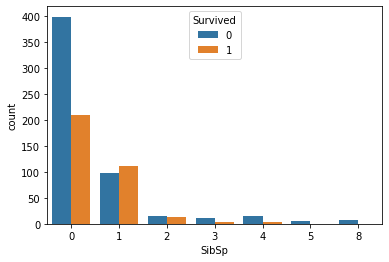

In [62]:
# 데이터의 갯수(집계)를 세서 bar차트로 시각화
sns.countplot(data = train,
             x="SibSp",
             hue="Survived")

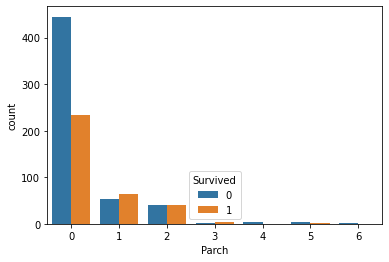

In [63]:
# 데이터의 갯수(집계)를 세서 bar차트로 시각화
sns.countplot(data = train,
             x="Parch",
             hue="Survived")

In [64]:
# 특성 공학 feature에 여러가지 연산을 시켜 새로운 컬럼을 만들어내는 작업
train["Family"] = train["SibSp"]+train["Parch"]

In [65]:
train["Family"]

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: Family, Length: 891, dtype: int64

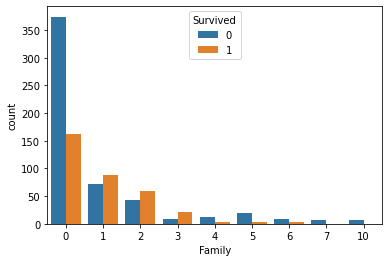

In [66]:
sns.countplot(data = train,
             x="Family",
             hue="Survived")

- 가족이 0명 일때 죽을 확률이 높다.
- 가족이 1~3명 일때 살 확률이 높다.
- 가족이 4명 이상 일때 죽을 확률이 높다.
- 가족은 수치형 데이터 타입이다.
- 구간화 작업을 통해 범주형 데이터로 만들고 모델에게 특성을 강조해보자.

##### binning

In [67]:
#3가지 필요 요소
#data
data = train["Family"]
#구간정보
bins = [-1,0,3,20]  # 세 구간의 시작점, 끝점
#구간의 이름
categori = ["Alone","Small","Large"]

test["Family"]=test["SibSp"]+test["Parch"]

train["Family_cat"]=pd.cut(data,bins=bins,labels=categori)
test["Family_cat"]=pd.cut(data,bins=bins,labels=categori)

In [68]:
display(train["Family_cat"])
display(test["Family_cat"])

0      Small
1      Small
2      Alone
3      Small
4      Alone
       ...  
886    Alone
887    Alone
888    Small
889    Alone
890    Alone
Name: Family_cat, Length: 891, dtype: category
Categories (3, object): [Alone < Small < Large]

0      Small
1      Small
2      Alone
3      Small
4      Alone
       ...  
413    Alone
414    Alone
415    Alone
416    Small
417    Small
Name: Family_cat, Length: 418, dtype: category
Categories (3, object): [Alone < Small < Large]

In [69]:
display(train["Family_cat"].value_counts().to_frame().style.background_gradient(cmap='Pastel1'))

,Family_cat
Alone,537
Small,292
Large,62


#### 비정형데이터(Name) 정형화

In [70]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Family_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,1,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,0,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,0,Alone


In [71]:
def split_title(name):
    return name.split(",")[1].split(".")[0].strip()
#strip() = 문자열의 좌 우 공백을 제거해주는 기능

In [72]:
train["Title"]=train["Name"].apply(split_title)
test["Title"]=test["Name"].apply(split_title)

In [73]:
display(train["Title"])
display(test["Title"])

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

0          Mr
1         Mrs
2          Mr
3          Mr
4         Mrs
        ...  
413        Mr
414      Dona
415        Mr
416        Mr
417    Master
Name: Title, Length: 418, dtype: object

#### 인코딩(문자 타입 -> 숫자타입)
- 원핫인코딩 : 순서가 없는 범주형 데이터를 0과 1로 표현하는 방법

- 순서가 없으면, One-hot Encoding
- 순서가 있으면, Label Encoding
- 순서가 없는 얘들에게 Label Encoding을 하면 순서가 부여되버린다.

In [74]:
pd.get_dummies(train["Sex"])#원핫인코딩을 해주는 함수

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [75]:
pd.get_dummies(train["Embarked"])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [76]:
pd.get_dummies(train["Cabin"], prefix="Cabin")# 한개만 인코딩할때 prefix로 키워드 달 수 있음

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,1,0
889,0,0,1,0,0,0,0,0,0


In [77]:
pd.get_dummies(train[["Cabin","Embarked"]])  # 컬럼 여러개도 가능 자동으로 키워드 달림

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0,0,0,1
887,0,1,0,0,0,0,0,0,0,0,0,1
888,0,0,0,0,0,0,0,1,0,0,0,1
889,0,0,1,0,0,0,0,0,0,1,0,0
